# TME 6 : Détection d'objets simples (I) : Détections de coins

> Consignes: le fichier TME6_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2019/course/view.php?id=4248. Si vous êtes en binôme, renommez-le en TME6_nom1_nom2.ipynb.

N'oubliez pas de sauvegarder fréquemment votre notebook !! ...

Pour chaque questions, écrivez des commentaires brefs et concis lorsque demandé dans les cases **Commentaires**.

In [1]:
# Chargement des modules et des données utiles.

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import scipy.signal
from pylab import *


# charger les images et les convertir en tableau de int
image_house = np.array(Image.open("images/house2.jpg"),dtype='int32') 
image_rectangle = np.array(Image.open("images/rectangle.png").convert('L'),dtype='int32')
image_carrelage = np.array(Image.open("images/carrelage_wikipedia.jpg"),dtype='int32')
image_jussieu = np.array(Image.open("images/Jussieu_wikipedia.jpg"),dtype='int32')


def affichage_14(affichages,titres=None):
    # list[Array|Image]*list[str] -> NoneType
    # effectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    # paramètres :
    #  - liste des affichages (entre 1 et 4)
    #  - liste des titres (entre 1 et 4, autant que de affichages) Optionnelle
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

    
def module_affichage(module):
    # permet de transformer un module de DFT en une version jolie à afficher
    module = np.array(module, dtype='float32')
    ind_max = np.where(module == np.max(module.flatten()))
    module[ind_max]=0.0
    module[ind_max]=np.max(module.flatten())
    module = sqrt(module)
    return sqrt(module)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Exercice 1 — Implémentation du filtre de Harris

Cet exercice est le prolongement de l’exercice 3 du TD 6. On cherchera ici à écrire des fonctions pour la détection de coins.

### Question 1 : Calcul des dérivées

On utilisera la fonction de convolution codée au TME 4 ou bien une fonction implémentée dans les librairies scientifiques de python (```scipy``` par exemple).

1. Écrire une fonction ```gradient()``` qui calcule la dérivée en $x$ et la dérivée en $y$ de l'image à l'aide des masques de convolution de Sobel et retourne une liste de ces dérivées. 

In [2]:
from scipy.signal import convolve2d

In [3]:
def gradient(image):
    """ Array -> tuple[Array*Array]"""
    sobelx = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])
    sobely = sobelx.T
    

    dx =  convolve2d(image, sobelx, "same")
    dy =  convolve2d(image, sobely, "same")
    
    
    return (dx, dy)
    
    

2. Visualiser la dérivée en $x$ et la dérivée en $y$ calculées pour les images ```image_house``` et ```image_rectangle```.

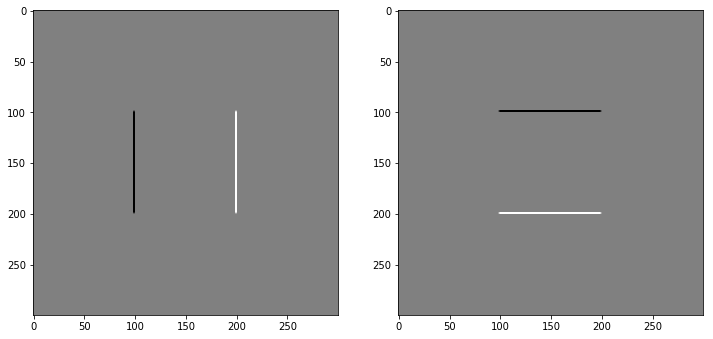

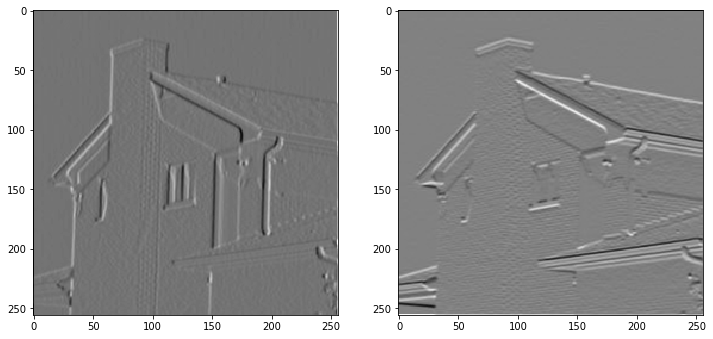

In [4]:
dx, dy = gradient(image_rectangle)

affichage_14([dx, dy])

dx, dy = gradient(image_house)

affichage_14([dx, dy])

### Question 2 : Noyau gaussien

1. Écrire la fonction ```noyau_gaussien(sigma)``` qui renvoie un tableau Numpy de taille $(2N+1)\times (2N+1)$, avec $N=\lceil3\sigma\rceil$ correspondant à un noyau gaussien centré en l'origine et d'écart-type $\sigma$.

In [5]:
import scipy.stats as st
def noyau_gaussien(sigma):
    """ float -> Array """
    
    x = np.linspace(-3*sigma, 3*sigma, int(6*sigma + 2))
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    
    return kern2d/kern2d.sum()
    

2. Afficher le noyau gaussien d'écart-type 3. Quelle taille fait-il? Même question avec un écart-type de 10.

(19, 19)


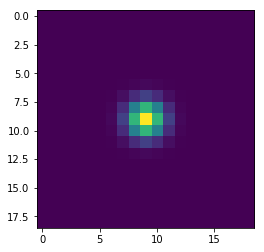

(61, 61)


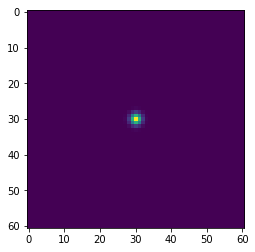

In [7]:
kern = noyau_gaussien(3)
print(kern.shape)
plt.imshow(kern)
plt.show()
kern = noyau_gaussien(10)
print(kern.shape)
plt.imshow(kern)

### Question 3 : Calcul de l'image de Harris

1. Écrire une fonction ```harris(image, sigma, kappa)``` qui calcule l'image de Harris.

In [8]:
def harris(image, sigma, kappa):
    """ Array*float*float->Array """
    # calcule des gradients
    Ix, Iy = gradient(image)
    
    gauss = noyau_gaussien(sigma)
    
    #calcule de A
    A11 = convolve2d(Ix*Ix, gauss, "same")
    A22 = convolve2d(Iy*Iy, gauss, "same")
    A12 = convolve2d(Ix*Iy, gauss,"same")
    
    # calcule de R
    det = (A11*A22) - (A12*A12)
    trace = A11 + A22
    
    R = det - kappa * trace**2 

    return R 
    

2. Visualisez l'image de Harris pour plusieurs images et plusieurs valeurs de paramètres.

(-0.5, 255.5, 255.5, -0.5)

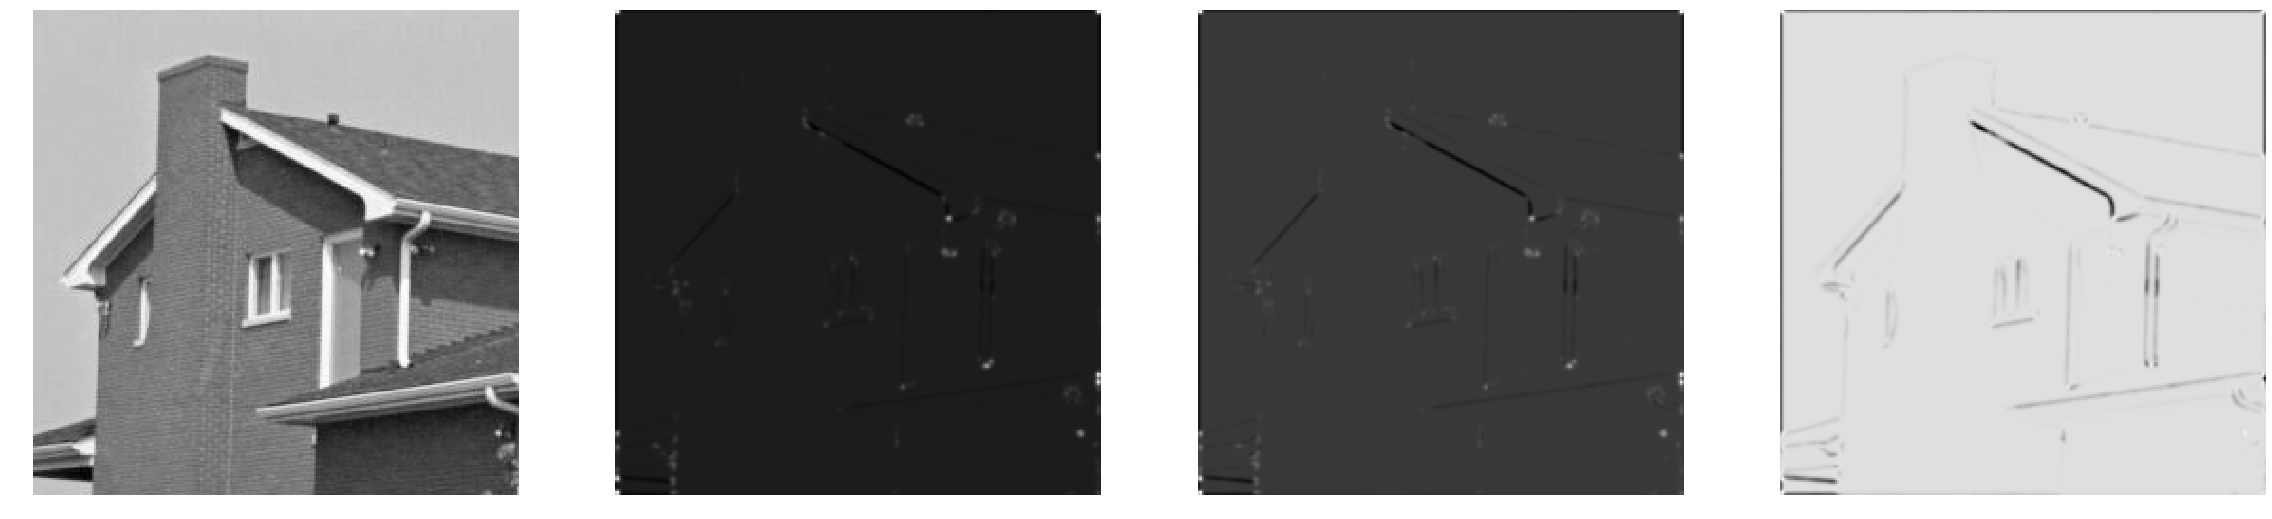

In [9]:
plt.figure(figsize=(40,160))
plt.subplot(141)
plt.imshow(image_house, cmap="gray")
plt.axis("off")

R = harris(image_house, 2 ,0.02)
plt.subplot(142)
plt.imshow(R, cmap="gray")
plt.axis("off")

R = harris(image_house, 6 ,0.04)
plt.subplot(143)
plt.imshow(R, cmap="gray")
plt.axis("off")

R = harris(image_house, 3,0.2)
plt.subplot(144)
plt.imshow(R, cmap="gray")
plt.axis("off")


## Exercice 2 : Seuillage et calcul des extrema locaux

On définit un maximum local comme un pixel dont la valeur est supérieur au seuil ```seuil``` et aux valeurs des 8 plus proches voisins. Dans cet exercice, on pourra ne pas traiter les pixels au bord de l'image.

### Question 1 :

1. Écrire un programme ```maxlocal(image_harris, seuil)``` qui prend en entrée une image de Harris et un seuil et qui renvoie un tableau numpy de même taille que l'image de Harris et dont les pixels correspondant à des maximum locaux sont à 1 et les autres à 0. On écrira une version avec parcours de l'image. Puis une version, de nom ```maxlocal_fast()``` sans parcours de l'image, uniquement à l'aide d'opération numpy 



In [10]:
def maxlocal(image_harris, seuil):
    """ Array*float -> Array """
    
    coin = np.zeros(image_harris.shape)

    for i in range(2, image_harris.shape[0]-2):
        for j in range(2, image_harris.shape[1]-2):
            
            if(np.amax(image_harris[i-1:i+2, j-1:j+2]) == image_harris[i, j]) and image_harris[i, j] > seuil:
                
                
                coin[i, j] = image_harris[i, j]
                #image_harris[i-1:i+2, j-1:j+2] = 0
                

    return np.array(coin)



    
def maxlocal_fast(image_harris, seuil):
    """Array*float -> Array"""
    
    # thresholding



    filtre = np.array([[-1, -1, -1],
                       [-1, +8, -1],
                       [-1, -1, -1]])
    
    coin = convolve2d(image_harris, filtre, "same")
    
        
    #non maximum supression   
    coin[coin < 0] = 0
    coin[coin > 0] = image_harris[coin > 0]
    coin[coin < seuil] = 0






    return coin
                    

2. Test la fonction ``maxlocal()`` sur l'image ``rectangle``. Afficher l'image des extrema et le nombre d'extrema détecté par la méthode d'Harris. Comparer les temps en utilisant cette fois la fonction ``maxlocal_fast()``.

In [11]:
from time import process_time
mytime = 0
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    print (process_time()-mytime)
    mytime = process_time()

11310057712.757586 -5474571221.851067
0.171875
0.015625


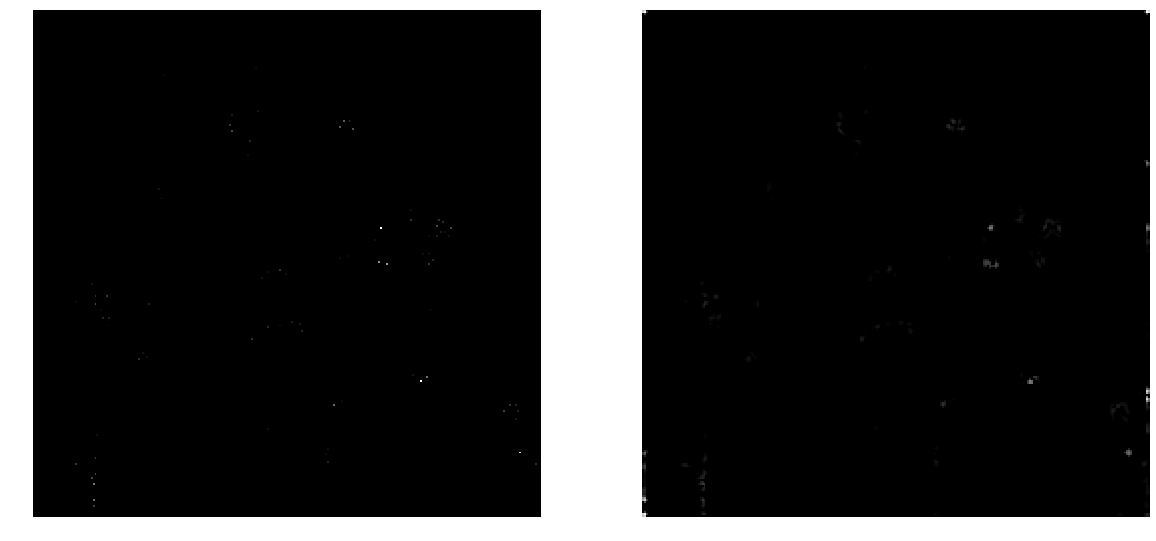

In [12]:
R = harris(image_house, 6, 0.06)

print(np.amax(R), np.min(R))

tic()
coin1 = maxlocal(R, 200000000)
tac()
tic()
coin2 = maxlocal_fast(R, 200000000)
tac()

plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.imshow(coin1, cmap="gray")
plt.axis("off")

plt.subplot(122)
plt.imshow(coin2, cmap="gray")
plt.axis("off")

plt.show()

2. Modifier le programme et écrire ``coord_maxlocal(image_extrema, seuil)`` pour qu'il renvoit une liste des coordonnées des maxima locaux trouvés dans ``image_extrema``. Une coordonnée est une liste de deux entiers. On testera cette fonction sur l'image ``image_rectangle`` en imprimant les coordonnées des maxima locaux.


In [32]:
from skimage.feature.blob import peak_local_max

def coord_maxlocal(image_extrema, seuil):
    """ Array*float -> list[list[int,int]] """
    
#     print("max extrema ", np.amax(image_extrema))
    
#     indecies = np.dstack(np.unravel_index(np.argsort(image_extrema.ravel()), (image_extrema.shape[0], image_extrema.shape[1])))
#     indecies = indecies.squeeze()

    
#     print("before", indecies.shape[0])
    
#     for i in range(len(indecies)):
#         if(image_extrema[indecies[i][0], indecies[i][1]] > 0):
#             print("i", i)
#             indecies = indecies[i:]
#             break
            
#     print("after",  indecies.shape[0])
    indecies = peak_local_max(image_extrema, 5)
    truc = int(seuil * indecies.shape[0] / 100)
    
#     print("pourcentage", truc, len(indecies))

#     return indecies[-truc:]
    return indecies
    

3. Visualisation: on souhaite supperposer les coins trouvées au dessus l''image. Les coins seront affichés sous la forme d'un cercle rouge. Ceci est possible à l'aide de la fonction ``scatter(x,y,color='red')`` du module ``matplotlib.pyplot``, où ``x`` est le vecteur des abscisses des points à afficher et ``y`` le vecteur des ordonnées correspondantes. Donner le code Python correspondant 
    

In [33]:
def test_harris(image, pourcent):

    R = harris(image, 1, 0.06)
    coin = maxlocal_fast(R, 20000000)
    # print(len(coin))
    ind = coord_maxlocal(coin,pourcent)
    ind = np.array(ind)
    # print(ind[-3:])
    plt.figure(figsize=(10,10))

#     plt.subplot(121)

    plt.imshow(image, cmap="gray")

    plt.axis('tight')
    plt.axis('off')
    
    plt.scatter(ind[:, 1], ind[:, 0], color="red",marker="o")
    
    plt.show()
#     plt.scatter(ind[:, 1], ind[:, 0], color="red",marker="+")

#     plt.subplot(122)
#     coin = maxlocal(R, 20000000)
#     # print(len(coin))
#     ind = coord_maxlocal(coin,100)
#     ind = np.array(ind)

#     plt.imshow(image, cmap="gray")

#     plt.axis('tight')
#     plt.axis('off')


# print("shit from line : ", coin[ind[0,0], ind[0,1]])

## Exercice 3 : Expérimentations

### Question 1
Expérimentez pour plusieurs images le détecteur de points de Harris avec plusieurs valeurs des paramètres sigma, kappa et seuil et en affichant l'image et les coins détectés en rouge.

Remarque importante: si les points détectés ne semblent pas correspondre visuellement à ce que vous voyez dans l'image, lisez la documentation de ```scatter()``` et revoyez éventuellement la fonction ``coord_maxlocal()``.


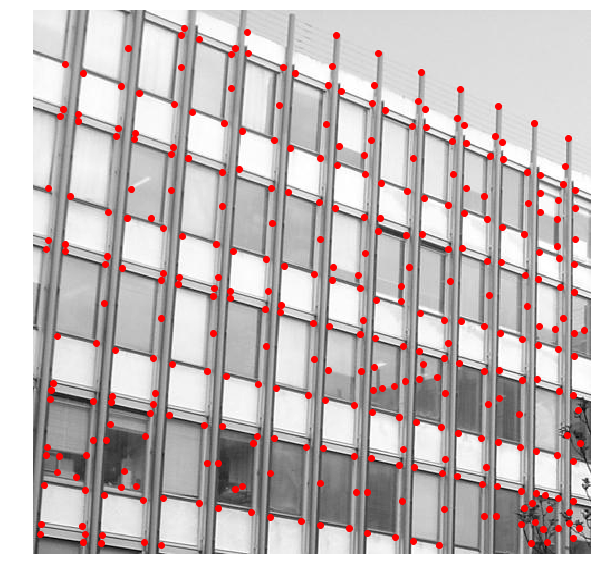

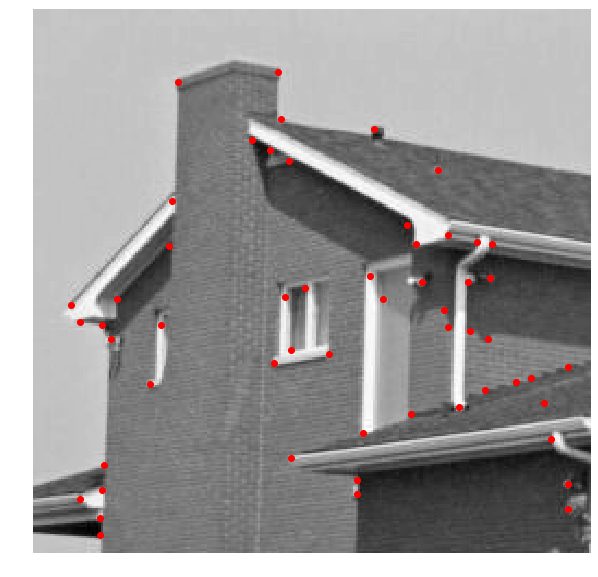

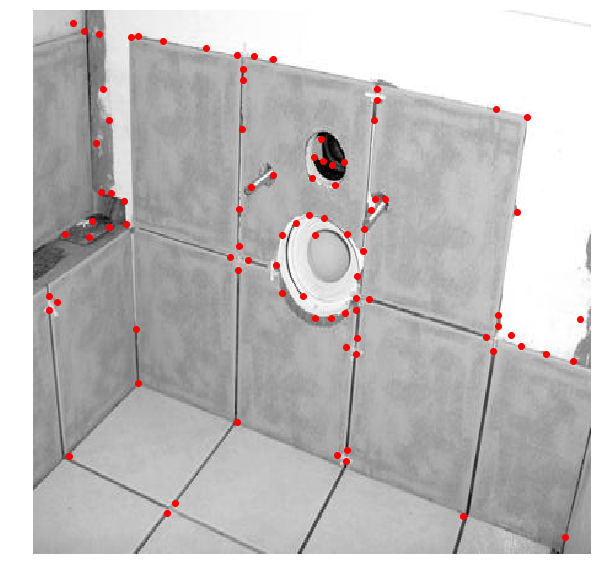

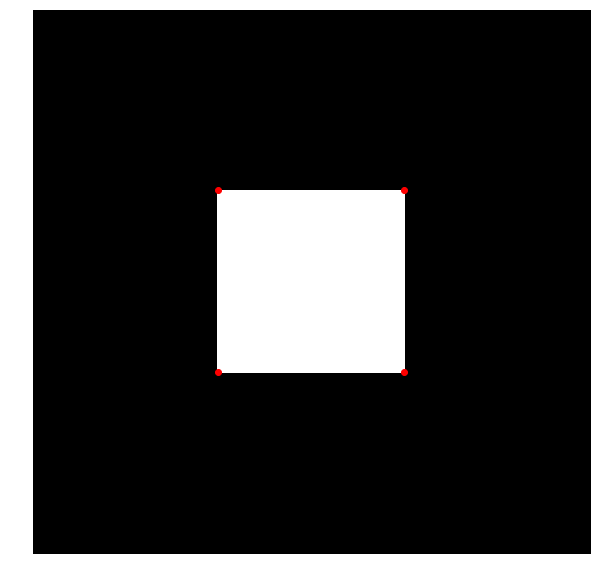

In [34]:
test_harris(image_jussieu, 100)
test_harris(image_house, 100)
test_harris(image_carrelage, 100)
test_harris(image_rectangle, 100)

### Question 2

Considerez le détecteur de point vu en cours, c'est-à-dire une convolution avec le noyau 
$\begin{pmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{pmatrix}$. Là encore, il faudra déterminer les maxima locaux ainsi que leur coordonnées pour les afficher.

